# Python Parallel Computing - Part 02

### Lecture 11

### Apr 12, 2023

Based on material here: https://nyu-cds.github.io/python-mpi/ (parts 4/5).


---
### Problem Decomposition
A central problem when working with MPI is to break the problem into “chunks” to be handled by individual processes.

There are two main ways to decompose a problem: 
- __Domain decomposition:__ Data associated with a problem is split into chunks and each parallel process works on a chunk of the data.
- __Functional decomposition:__ Focus is on the computation rather than on the data. Used when pieces of data require different processing.

- can achive a good speed up if paralyze the problem 
- domain decompostion:
    - each part of the program takes a subsection of the domain then they are combined, also works with found data 
- functional decomposition
    - bassically break the tasks instead of the data to go to difrent cores
    - like we need to count the number of poeple in a dataset named greg 
    - and we seperatly need to count the number of poeple in a dataset named tom


---

<img src="domain_decomp.png" style="width: 800px;"/>

- big data set that can be what ever it is
- break the feature set into smaller pieces, do the processing within each core

<img src="funct_decomp.png" style="width: 1000px;"/>

- functional decomposition is similar. 
- break the tasks into chunks that can be done in parallel

---

#### Example of a domain decompostion with MPI





**Hermite interpolation:**

Concretelly, for example, we want to interpolate $$p(x) = ax^3+bx^2+cx+d$$ where $$p'(x) = 3ax^2 + 2b x + c$$ 
and have the following estimates: $y_0 = p(x_0), y_1 = p(x_1)$ and $m_0 = p'(x_0), m_1 = p'(x_1)$.



<img src="img8.png" alt="Drawing" style="width: 300px;"/>
$$
\begin{array}{l}
ax_0^3+bx_0^2+cx_0+d = y_0\\
ax_1^3+bx_1^2+cx_1+d = y_1\\
3ax_0^2+2bx_0+c = m_0\\
3ax_1^2+2bx_1+c = m_1
\end{array}
\Longrightarrow
\left[\begin{array}{cccc}
x_0^3 & x_0^2 & x_0 & 1\\
x_1^3 & x_1^2 & x_1 & 1\\
3x_0^2 & 2x_0 & 1 & 0\\
3x_1^2 & 2x_1 & 1 & 0
\end{array}\right]
\left[\begin{array}{c}
a\\
b\\
c\\
d
\end{array}\right]=
\left[\begin{array}{c}
y_0\\
y_1\\
m_0\\
m_1
\end{array}\right]
$$

- have a polynomial, of degree 3. can tak eht edarivative. 
- observe points and have there derivatives, want to observe the right numeber of points to solve hte linear system 
- solve it using gaussian decomposition. so we are estimating the function given a fixed number of datapoints interpolation. 


In [1]:
def hermite(data):
    """
    data in the form: [x[i], x[i+1], y[i], y[i+1], m[i], m[i+1]] ## 6 data points 2 x 2 y 2 darivatives. 
    """
    ## want to esimate a b, c,d
    A = np.zeros((4,4))
    pts = []

    #create A and b for the linear system
    A[0:2] = np.array([np.power(data[0:2], 3), np.power(data[0:2], 2), data[0:2],np.array([1,1])]).T
    A[2:4] = np.array([3*np.power(data[0:2],2), 2*data[0:2],np.array([1,1]), np.array([0,0])]).T
    b = data[2: ]
    
    #solve the linear system A * coefs = b 
    coefs = np.linalg.solve(A, b) ## gaussian solve this 
    
    # interpolate polynomial on [x[i], x[i+1]] in 100 points
    t = np.linspace(data[0], data[1], 100) ## assume that the function is at the same darivative within that 
    pts.extend(np.polyval(coefs, t)) ## evaluate ti 
    
    return pts 

- starting tests
- simulated exampels generate data, and see if you are optimizing correctly. 
- the bellow plot is simulation 
- erorr is indpednt random varibles so by central liit therome it is gaussian. 
- 

Took 0.47907400131225586s


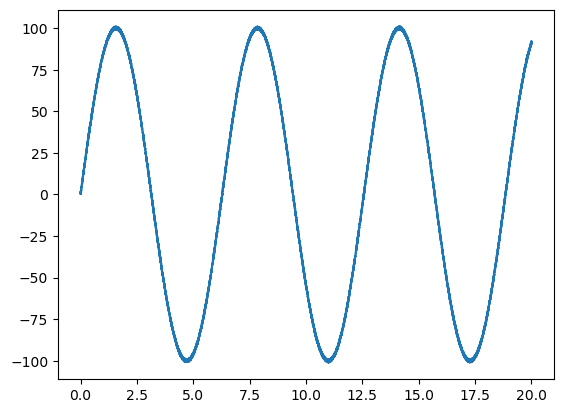

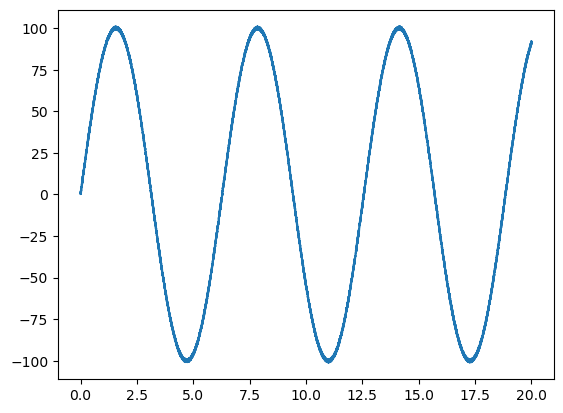

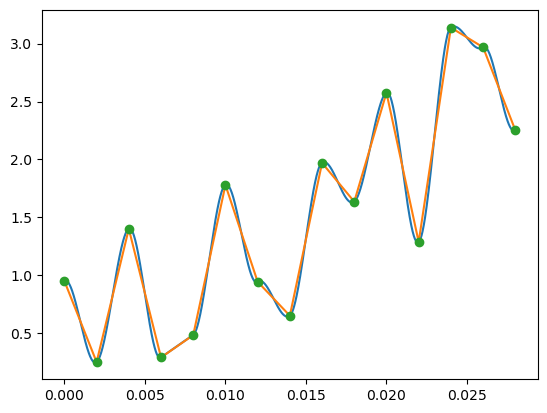

In [5]:
#####
# Finding the piece-wise hermite polynomial interpolation of a set of points
# Sequential version
#####
## here we are simulating, and running tests. 
#

from time import time
import numpy as np
import matplotlib.pyplot as plt

ts = time()
numx = 10000   # number of discretized points in x ## doman 
##
x = np.linspace(0, 20, numx)
y = np.random.uniform(low=-1,high=1, size=numx) + 100 * np.sin(x) ## get y as a scalled sin function with some noise
m = np.random.uniform(low=-1, high=1, size=numx) + 100 * np.cos(x) ## and its derivative also with some ranomm noise. 
## iterate through numebr of data points
l = [] ##
for i in range(numx - 1):
    data = np.array([x[i], x[i+1], y[i], y[i+1], m[i], m[i+1]]) #3 consturct data extne by coefcents
    l.extend(hermite(data)) ## then plot 
   

print('Took {}s'.format(time() - ts))

plt.figure()
plt.plot(x, y)

s = np.linspace(0, 20, len(l))
plt.figure()
plt.plot(s, l)

plt.figure()
end = 15
plt.plot(s[0:100*(end-1)], l[0:100*(end-1)])
plt.plot(x[0:end], y[0:end])
plt.plot(x[0:end], y[0:end],'o')
plt.show()

## does look like 100 times sign
## looks pretty similar overall. 
## interpolations, we are doing well in a small range

- now we are making this paralel
- we are doing a lot of extend functions on difrent chunks 

In [2]:
%%writefile mpi08.py
#####
# Finding the piece-wise hermite polynomial interpolation of a set of points
# MPI version
#####
from time import time
import numpy as np
import matplotlib.pyplot as plt
import numpy
from mpi4py import MPI

comm = MPI.COMM_WORLD ## this is all consistent with what we saw last time. 
rank = comm.Get_rank()
size = comm.Get_size()
status = MPI.Status()

ts = time()
numx = 10_000
rank_interval_size = 20 / size
numx_per_rank = int(np.floor(numx / size))

m = np.zeros((numx_per_rank,))

def hermite(data):
    A = np.zeros((4, 4))
    pts = []

    A[0:2]=np.array([np.power(data[0:2], 3),np.power(data[0:2],2),data[0:2],np.array([1,1])]).T
    A[2:4]=np.array([3*np.power(data[0:2],2),2*data[0:2],np.array([1,1]),np.array([0,0])]).T
    b = data[2:]
    coefs = np.linalg.solve(A,b)
    t = np.linspace(data[0], data[1], 100)
    pts.extend(np.polyval(coefs,t))
    return(pts)


if rank == 0: ## if rank=0 is teh controller node 
    l = []
    x = np.linspace(0, rank_interval_size, numx_per_rank)
    y = np.random.uniform(low=-1, high=1, size=numx_per_rank) + 100 * np.sin(x)
    for i in range(numx_per_rank-1):
        data = np.array([x[i], x[i+1], y[i], y[i+1], m[i], m[i+1]])
        l.extend(hermite(data))
        
    # Process 0 serves also as receiver
    pts = np.zeros((np.asarray(l).shape[0], )) 
    for p in range(1, size): ## recives things from all the other sources 
        comm.Recv(pts, source=p) ## after the recive we  extnet adn save into a file 
        l.extend(np.ndarray.tolist(pts))
        
    np.save('mpi_hermite_cpt.npy', np.asarray([x, y]))
    np.save('mpi_hermite.npy', np.asarray(l)) #store numpy data

else:
    l = []
    x = np.linspace(rank*rank_interval_size,(rank + 1)*rank_interval_size, numx_per_rank)
    y = np.random.uniform(low=-1,high=1, size=numx_per_rank) + 100 * np.sin(x)
    for i in range(numx_per_rank-1):
        data = np.array([x[i], x[i+1], y[i], y[i+1], m[i], m[i+1]])
        l.extend(hermite(data))
    
    pts = np.asarray(l) 
    comm.Send(pts,dest=0) ## finally send to destiaion =0
    
print('Rank ',rank,' Took {}s'.format(time() - ts))

Writing mpi08.py


In [ ]:
!mpiexec -n 4 python3 mpi08.py

(2, 2500) (999600,)


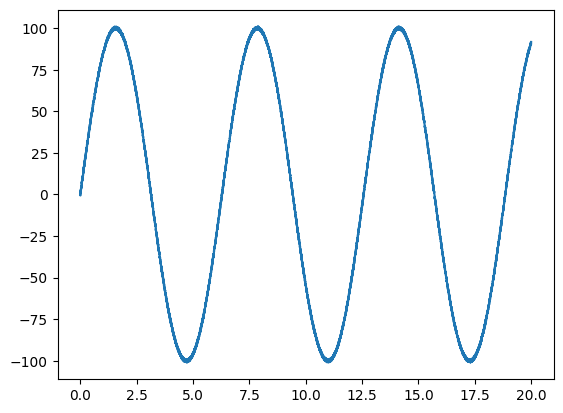

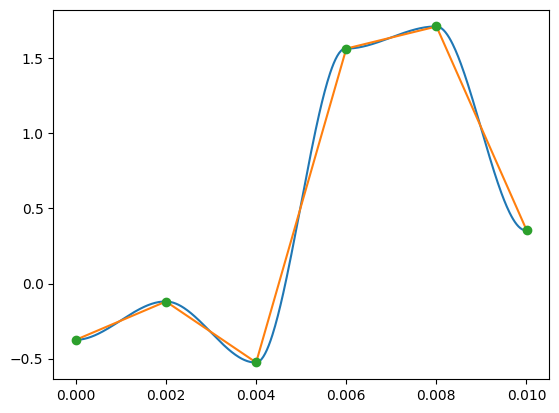

In [5]:
import numpy as np
import matplotlib.pyplot as plt
ctp = np.load('mpi_hermite_cpt.npy')
r = np.load('mpi_hermite.npy')
print(ctp.shape, r.shape)

s = np.linspace(0, 20, r.shape[0])
plt.figure(1)
plt.plot(s, r)
plt.figure(2)
plt.plot(s[0:500],r[0:500])
plt.plot(ctp[0,0:6], ctp[1,0:6])
plt.plot(ctp[0,0:6], ctp[1,0:6],'o')
plt.show()
## still does well 

- Xb projects observations back to col space. 
- try to have a geometric space
- objcetive of logistic loss is mle with logistic loss 
- 

---
## Collective Operations: point-to-point vs collective communication

__Collective communication__ allows to send data between multiple processes of a group simultaneously and the most common operations are: 

- **Synchronization**
  - Processes wait until all members of the group have reached the synchronization point
- **Global communication functions**
  - Broadcast data from one member to all members of a group
  - Gather data from all members to one member of a group
  - Scatter data from one member to all members of a group
- **Collective computation (reductions)**
  - One member of the group collects data from the other members and performs an operation (min, max, add, multiply, etc.) on that data.
- **Collective Input/Output**
  - Each member of the group reads or writes a section of a file.

#### **Synchronization**
MPI has a special function that is dedicated to synchronizing processes: __comm.Barrier()__. No process advances until all have called the function.
$$
\begin{array}{cc|c}
& \bigcirc & \\
\bigcirc& 	 & \\
& 	\bigcirc & 
\end{array}
\Rightarrow
\begin{array}{cc|c}
& \bigcirc & \\
& \bigcirc	 & \\
& 	\bigcirc & 
\end{array}
\Rightarrow
\begin{array}{cc|c}
& &\bigcirc  \\
& &\bigcirc	  \\
& &	\bigcirc  
\end{array}
$$


<img src="comm_barrier.png" style="width: 400px;"/>

- point to point, send data to destination, 
- coecletive comnncation can reie anyhting from any node
- does not have to be point to point is the macro level message
- the first thing is synchronization, effectivly thehre is a function com barrirer in which every function must call this function before they can cproceed. this wouuld be helpfull fi all are acessing the same pice of memory, and to ensure tha th ressult is good 
- there is a global comuncaiton there is a single node that sends messages to all the other nodes/ 
- there is also a fucntion called scatter that distributed difrent pices of data to difrent pieces. 
- can send anything within the buffer to other nodes, there is send bugger that gets sendt to recive function 
- gather takes data from many other nodes, and combines them all toghter. 
- gather is a good function 
- there is also reduce function, it is similar to gather. gather is a pre-requisti to gather. it is kind of like map reduce type beat 
- the namining is kind of strait forward we are going to see somme examples except for break 
0 there is all tot all 
- file open 
- file write all 


---

### Global communication functions

For detailed diagrams see: [https://nyu-cds.github.io/python-mpi/05-collectives/](https://nyu-cds.github.io/python-mpi/05-collectives/)

Examples here: https://mpi4py.readthedocs.io/en/stable/tutorial.html#collective-communication

---




#### **Broadcasting**
One process sends the same data to all processes in a communicator using the command __comm.Bcast(buf, root=0)__.


<img src="broadcast.png" style="width: 400px;"/>

#### **Scatter**
Broadcast sends the same piece of data to all processes while scatter sends chunks of an array to different processes. 


<img src="scatter.png" style="width: 400px;"/>

__Comm.Scatter(sendbuf, recvbuf, root=0)__ method takes three arguments. The first is an array of data that resides on the root process. The second parameter is used to hold the received data. The last parameter indicates the root process that is scattering the array of data.


#### **Gather**
Gather is the inverse of scatter, taking elements from many processes and gathering them to one single process.

<img src="gather.png" style="width: 400px;"/>

__Comm.Gather(sendbuf, recvbuf, root=0)__ method takes the same arguments as __Comm.Scatter__.


#### **Reduction**
__Comm.Reduce(sendbuf, recvbuf, op=MPI.SUM, root=0)__ handles almost all of the common reductions that a programmer needs to do in a parallel application.

<img src="reduction.png" style="width: 400px;"/>


__Comm.Reduce__ takes an array of input elements and returns an array of reduced elements to the root process.
- MPI.MAX - Returns the maximum element.
- MPI.MIN - Returns the minimum element.
- MPI.SUM - Sums the elements.
- MPI.PROD - Multiplies all elements.

#### **Other Colletive Operations**
- __Comm.Alltoall(sendbuf, recvbuf)__
- __File.Open(comm, filename, amode, info)__
- __File.Write_all(buffer)__

---
#### Computing an integral using parallel collective version 

In [11]:
%%writefile mpi09.py
import numpy
from math import sin
from mpi4py import MPI

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

def integral(a_r, h, n): ## thhis is a numerical intergration for sign of t on this given range 
    integ = 0.0 
    for j in range(n):
        t = a_r + (j + 0.5) * h
        integ += sin(t) * h
    return integ ## h is the bin width. integration is good for parralelim. in the end we sum them.


a = 0.0 ## start
b = numpy.pi / 2 #3 end
dest = 0
my_int = numpy.zeros(1) 
integral_sum = numpy.zeros(1)

# Initialize value of n only if this is rank 0
if rank == 0: ## default values
    n = numpy.full(1, 500, dtype=int) # default value
    ## rank zero 
else:
    n = numpy.zeros(1, dtype=int)

# Broadcast n to all processes
print("Process ", rank, " before n =", n[0])
comm.Bcast(n, root=0) ## sending thi svalue to all other nodes 
print("Process ", rank, " after n =", n[0])

# Compute partition
h = (b - a) / (n * size) # calculate h *after* we receive n
a_r = a + rank * h * n
my_int[0] = integral(a_r, h, n[0])

# Send partition back to root process, computing sum across all partitions
print("Process ", rank, " has the partial integral ", my_int[0])  ##  find the partial integral
comm.Reduce(my_int, integral_sum, MPI.SUM, dest) ## add the partial integrals 

# Only print the result in process 0
if rank == 0:
    print('The Integral Sum =', integral_sum[0])


Writing mpi09.py


In [ ]:
!mpiexec -n 4 python mpi09.py

### Matrix-vector multiplication

Parallelize $y = Ax$ over the rows of $A$.

$$
\begin{pmatrix}y_1 \\ \vdots \\ y_k \end{pmatrix} = \begin{pmatrix}A_1 \\ \vdots \\ A_k \end{pmatrix} x
$$

- doing matrix vector multiplication 
- even linear regression is matrix vector multiplication 
- want to find matrix to vector product. 
- sparse matrix, missing a lot of values or has a lot of zeros. 
- rank of the matrix, min number of rows or cols that are li
- rank of square matrix, number of square non-zero eigenvalues
- identity matrix is sparse but full rank 
- or just keep the non zero values of a sparse matrix.  
- make a matrix a list want the pairs where the matrix has non-zero components.
- can store identity matirx as just the n locations of the zero values. 
- low rank, sparse compute the vector of eigenvalues. the vector of eigen values of a sparse matrix its self is sparse. 
- nuclear norm of a matrix is the sum of the singular values. the idea is that in image processing, can optimze for a more sparse matriix
will return a more now low rank version of a 
- kinda like doing lasso, on the eigenvalues of our matrix to make sure that we get as sparse a matrix as possible.
- if matrix a is dense there is not a great way to paralize Ax, if it is sparse, you can do it easily
- only have to take the multiplciation of the non zero values. 

In [12]:
%%writefile mpimatvec.py

from mpi4py import MPI
import numpy as np

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

n = size * 2  
m = 5
if rank == 0:
    A = np.random.randn(n, m) ## n by m random numbers
    x = np.random.randn(m) ## x is m 

    ytarget = A.dot(x) # to check the result, the ground truth. 
    
    A = A.reshape(size, -1, m) ## reshape a into the matrix
else: 
    A = None ## does not overwirte A 
    x = np.zeros(m) ## sets x to a zero vector

Asmall = np.zeros((n // size, m)) ## a smaller version of

# Asmall = comm.scatter(A, root=0)
comm.Scatter(A, Asmall, root=0) ## we are scattering A so that each process gets a bit of A. dont have to tell how to send out the data i
# it will do that on it's own.  need to specfiy the ugger and the hroot tho 

# x = comm.bcast(x, root=0)
comm.Bcast(x, root=0) ## braodcast x becuase it is same for everyone 

print('rank', rank, ':', Asmall.shape, x.shape)

ysmall = Asmall.dot(x) ## a smal y

# y = comm.gather(ysmall, root=0)
y = np.zeros((size, n // size)) ## intilize y
comm.Gather(ysmall, y, root=0) ## gether 

if rank == 0:
    print(np.concatenate(y)) ## concat those fatherd
    print(ytarget) ## print them out. 
## ends up working out well. 
## 


Writing mpimatvec.py


In [ ]:
!mpiexec -n 4 python mpimatvec.py

In [8]:
import numpy as np
A = np.random.randn(4, 5)
x = np.random.randn(5)

A.dot(x)

array([-1.45282461,  0.17710213, -3.41932223, -2.17579918])

### Communication of buffer-like objects
When using the upper case version of the methods (Send, Irecv, Gather, etc.) the data object must support the **single-segment buffer interface**. This interface is a standard Python mechanism provided by some types (e.g., strings and numeric arrays), which is why we have been using NumPy arrays in the examples.

### Communication of generic Python objects
It is also possible to transmit an arbitrary Python data type using the lower case version of the methods (send, irecv, gather, etc.) mpi4py will **serialize** the data type, send it to the remote process, then **deserialize** it back to the original data type (a process known as **pickling** and **unpickling**). While this is simple, it also adds significant overhead to the MPI operation.